# Preprocessing data

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

train = pd.read_csv("../data/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)

def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))

# Get the number of reviews based on the dataframe column size
num_reviews = train["review"].size

# Initialize an empty list to hold the clean reviews
clean_train_reviews = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
for i in xrange( 0, num_reviews ):
    # Call our function for each one, and add the result to the list of
    # clean reviews
    clean_train_reviews.append( review_to_words( train["review"][i] ) )
    
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

# More efficient parameter tuning using `GridSearchCV`

In [2]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline 

X = train_data_features
y = train["sentiment"]

regularization_vals=[0.01, 0.05, 0.1, 0.5, 1.0]
param_grid=dict(C=regularization_vals)

grid = GridSearchCV(LogisticRegression(), param_grid, cv=10, scoring='roc_auc', n_jobs = -10) # use all available processors
grid.fit(X, y)

grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
grid.best_estimator_

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

TypeError: There is no line property "maxlags"

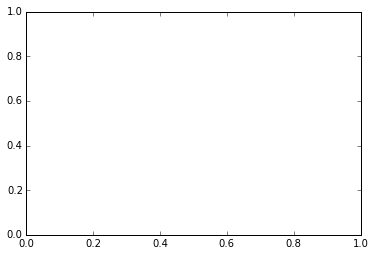

In [3]:
plt.plot(regularization_vals, grid_mean_scores, maxlags=None)
plt.xlabel('Value for C (reverse regularization)')
plt.ylabel('Cross-validated accuracy')

Let's start with a fresh train-test split and apply the regularization of < 0.1

In [4]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score as AUC

X = train_data_features
y = train["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)
lr = LogisticRegression(C=0.02)
lr = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

prob = lr.predict_proba( X_test )
auc = AUC(y_test, prob[:,1])
print auc # 0.941214027606

y_pred = grid.best_estimator_.predict_proba(X_test)
prob = lr.predict_proba( X_test )
auc = AUC(y_test, prob[:,1])
print auc # 0.941214027606


0.941214027606
0.941214027606


## Create Submission

In [ ]:
# Read the test data
test = pd.read_csv("data/testData.tsv", header=0, delimiter="\t", quoting=3 )

# Verify that there are 25,000 rows and 2 columns
print test.shape

# Create an empty list and append the clean reviews one by one
num_reviews = len(test["review"])
clean_test_reviews = [] 

print "Cleaning and parsing the test set movie reviews...\n"
for i in xrange(0,num_reviews):
    clean_review = review_to_words( test["review"][i] )
    clean_test_reviews.append( clean_review )

# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(clean_test_reviews).toarray()

# Use the random forest to make sentiment label predictions
result = grid.best_estimator_.predict(test_data_features)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

# Use pandas to write the comma-separated output file
output.to_csv( "Bag_of_Words_model.csv", index=False, quoting=3 )